In [1]:
"""We define the class for simulating the Fitzhugh-Nagumo model."""

import torch
import matplotlib.pyplot as plt
import math
import spectre.model
import spectre.spectrum_general
from spectre.model import FHN
from spectre.spectrum_general import matrix_solution
from spectre.spectrum_general import sim_solution
from spectre.spectrum_general import element_wise
import os
import numpy as np

os.chdir("..")
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

fileloc = r"figures/FHN/"

In [2]:
"""Define the circuit"""

eta1 = 0.00  # S.D. of the noise
eta2 = 0.001  # S.D. of the noise
I = 0.265
model = FHN(I=I, eta1=eta1, eta2=eta2)

In [3]:
"""Define the simulation parameters"""

ndivs = 15
n_points = int(2e6)
time = 25000
dt = 0.5e-1

In [4]:
"""Define the frequency vectors"""

min_freq = 1e-3
max_freq = 10
n_freq_mat = 100
n_freq_rat = 1000

"""Define the frequency vectors for the matrix and rational solutions"""
freq_mat = torch.logspace(np.log10(min_freq), np.log10(max_freq), n_freq_mat)
freq_rat = torch.logspace(np.log10(min_freq), np.log10(max_freq), n_freq_rat)

In [5]:
"""Find auto-spectra of v using different schemes"""

idx = 0

"""Analytical solution (matrix)"""
mat_model = matrix_solution(model.J, model.L, model.S)
psd_matrix, _ = mat_model.auto_spectrum(idx, freq_mat)

"""Analytical solution (rational polynomial)"""
rat_model = element_wise(model.J, model.L, model.S)
psd_rational, _ = rat_model.auto_spectrum(idx, freq_rat)

"""Simulation solution"""
sim_model = sim_solution(model)
psd_sim, f = sim_model.simulation_spectrum(
    i=idx, ndivs=ndivs, n_points=n_points, time=time, dt=dt
)

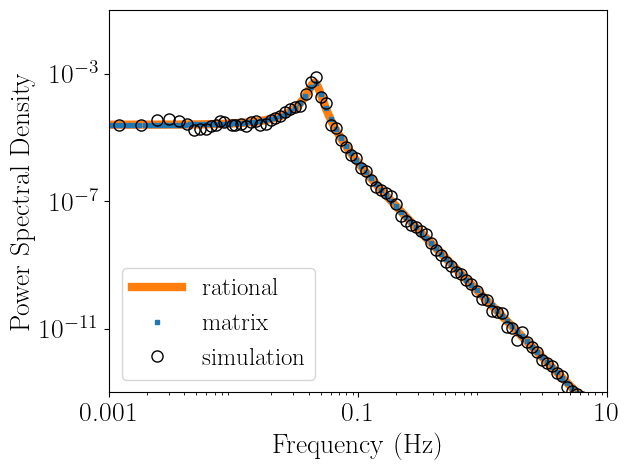

In [6]:
plt.figure(1)
idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
plt.loglog(freq_rat, psd_rational, label="rational", linewidth=6, color="C1")
plt.loglog(
    freq_mat,
    psd_matrix,
    label="matrix",
    linewidth=0,
    marker="s",
    markersize=2.5,
    color="C0",
)
plt.loglog(
    f[idx_closest],
    psd_sim[idx_closest],
    label="simulation",
    linewidth=0,
    marker="o",
    markersize=8,
    markerfacecolor="none",
    color="k",
)
plt.legend(fontsize=18, loc="lower left")
plt.xlabel("Frequency (Hz)", fontsize=20)
plt.ylabel("Power Spectral Density", fontsize=20)
plt.xticks([1e-3, 1e-1, 10], ["0.001", "0.1", "10"], fontsize=20)
plt.yticks([1e-11, 1e-7, 1e-3], fontsize=20)
plt.xlim([1e-3, 10])
plt.ylim([1e-13, 1e-1])
plt.tight_layout()
plt.savefig(fileloc + "psd_fhn.svg", format="svg", dpi=1200)
plt.show()

In [7]:
"""Plot the simulated spectrum of the membrane potential and the one using the formula"""

idx = 0

"""Simulation spectrum"""
sim_model = sim_solution(model)
psd_sim, f = sim_model.simulation_spectrum(
    i=idx, ndivs=ndivs, n_points=n_points, time=time, dt=dt
)

"""Formula spectrum"""
f_psd = model.psd_v(freq_rat)

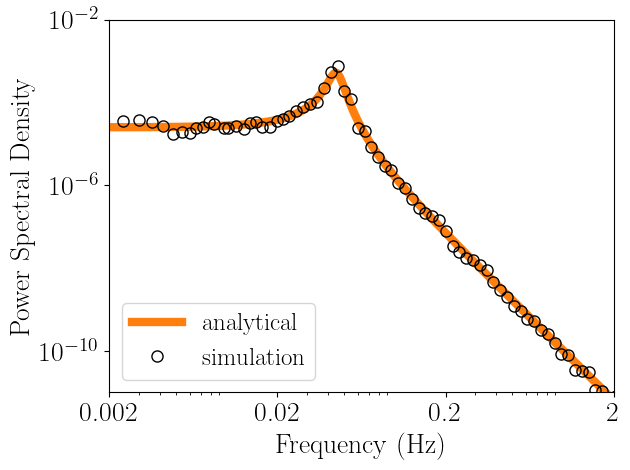

In [8]:
plt.figure(2)
idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
plt.loglog(freq_rat, f_psd, label="analytical", linewidth=6, color="C1")
plt.loglog(
    f[idx_closest],
    psd_sim[idx_closest],
    label="simulation",
    linewidth=0,
    marker="o",
    markersize=8,
    markerfacecolor="none",
    color="k",
)
plt.legend(fontsize=18, loc="lower left")
plt.xlabel("Frequency (Hz)", fontsize=20)
plt.ylabel("Power Spectral Density", fontsize=20)
plt.xticks([0.002, 0.02, 0.2, 2], ["0.002", "0.02", "0.2", "2"], fontsize=20)
plt.yticks([1e-10, 1e-6, 1e-2], fontsize=20)
plt.xlim([0.002, 2])
plt.ylim([1e-11, 1e-2])
plt.tight_layout()
plt.savefig(fileloc + "psd_fhn_formula.svg", format="svg", dpi=1200)
plt.show()

In [9]:
"""Find cross-spectra of v and w using different schemes"""

i = 0
j = 1

"""Analytical solution (matrix)"""
mat_model = matrix_solution(model.J, model.L, model.S)
cpsd_matrix, _ = mat_model.cross_spectrum(i, j, freq_mat)

"""Analytical solution (rational polynomial)"""
rat_model = element_wise(model.J, model.L, model.S)
cpsd_rational, _ = rat_model.cross_spectrum(i, j, freq_rat)

"""Simulation solution"""
sim_model = sim_solution(model)
cpsd_sim, f = sim_model.simulation_spectrum(
    i=i, j=j, ndivs=ndivs, n_points=n_points, time=time, dt=dt
)

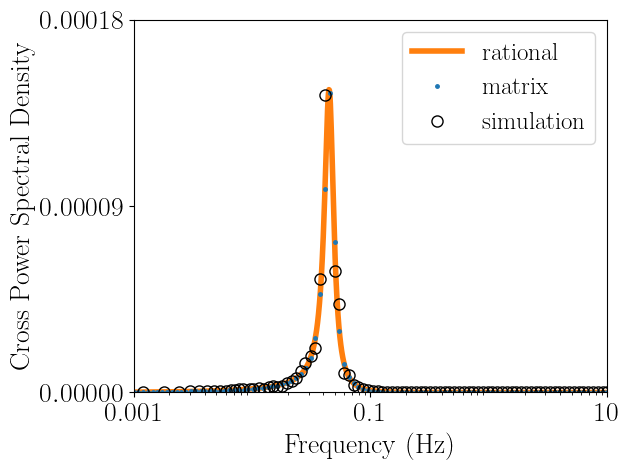

In [10]:
plt.figure(3)
idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
plt.semilogx(
    freq_rat, torch.abs(cpsd_rational), label="rational", linewidth=4, color="C1"
)
plt.semilogx(
    freq_mat,
    torch.abs(cpsd_matrix),
    label="matrix",
    linewidth=0,
    marker="o",
    markersize=2.5,
    color="C0",
)
plt.semilogx(
    f[idx_closest],
    torch.abs(cpsd_sim[idx_closest]),
    label="simulation",
    linewidth=0,
    marker="o",
    markersize=8,
    markerfacecolor="none",
    color="k",
)
plt.legend(fontsize=18, loc="upper right")
plt.xlabel("Frequency (Hz)", fontsize=20)
plt.ylabel("Cross Power Spectral Density", fontsize=20)
plt.xticks([1e-3, 1e-1, 10], ["0.001", "0.1", "10"], fontsize=20)
plt.yticks([0, 0.00009, 0.00018], fontsize=20)
plt.xlim([1e-3, 10])
plt.ylim([0, 0.00018])
plt.tight_layout()
plt.savefig(fileloc + "cpsd_fhn_absolute.svg", format="svg", dpi=1200)
plt.show()

In [11]:
"""Plot the coherence between v and w"""

# Note here that coherence is 1 for all frequencies because no noise is added to v.
i = 0
j = 1

"""Analytical solution (matrix)"""
mat_model = matrix_solution(model.J, model.L, model.S)
coh_matrix, _ = mat_model.coherence(i=i, j=j, freq=freq_mat)

"""Analytical solution (rational polynomial)"""
rat_model = element_wise(model.J, model.L, model.S)
coh_rational, _ = rat_model.coherence(i, j, freq_rat)

"""Simulation solution"""
sim_model = sim_solution(model)
coh_sim, f = sim_model.simulation_coherence(
    i=i, j=j, ndivs=ndivs, n_points=n_points, time=time, dt=dt
)

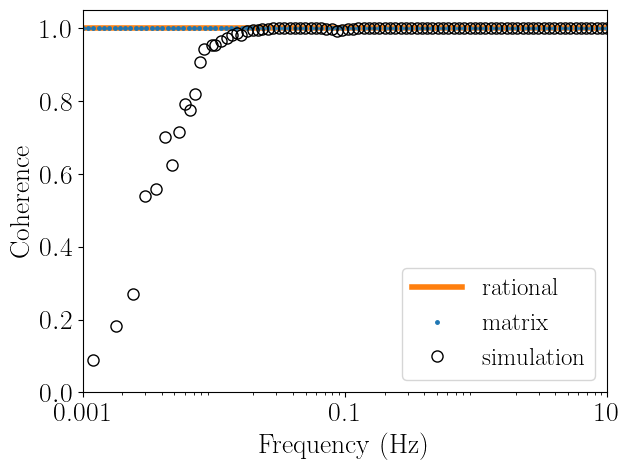

In [12]:
plt.figure(4)
idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
plt.semilogx(
    freq_rat, torch.abs(coh_rational), label="rational", linewidth=4, color="C1"
)
plt.semilogx(
    freq_mat,
    torch.abs(coh_matrix),
    label="matrix",
    linewidth=0,
    marker="o",
    markersize=2.5,
    color="C0",
)
plt.semilogx(
    f[idx_closest],
    torch.abs(coh_sim[idx_closest]),
    label="simulation",
    linewidth=0,
    marker="o",
    markersize=8,
    markerfacecolor="none",
    color="k",
)
plt.legend(fontsize=18, loc="lower right")
plt.xlabel("Frequency (Hz)", fontsize=20)
plt.ylabel("Coherence", fontsize=20)
plt.xticks([1e-3, 1e-1, 10], ["0.001", "0.1", "10"], fontsize=20)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
plt.xlim([1e-3, 10])
plt.ylim([0, 1.05])
plt.tight_layout()
plt.savefig(fileloc + "coh_fhn.svg", format="svg", dpi=1200)
plt.show()